CPU times: user 87.2 ms, sys: 60.5 ms, total: 148 ms
Wall time: 146 ms


3455097

In [2]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = GATConv(in_dim, out_dim, heads=1)#这里in_dim和out_dim都=dim=256
        # self.gatconv = GATConv(256, 256, heads=1)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

losslist_ppigeniepath=[]
for epoch in range(1, 101):
    loss = train()
    losslist_ppigeniepath.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))


Epoch: 01, Loss: 0.5674, Val: 0.4759, Test: 0.4773
Epoch: 02, Loss: 0.5262, Val: 0.5081, Test: 0.5113
Epoch: 03, Loss: 0.5126, Val: 0.4965, Test: 0.5019
Epoch: 04, Loss: 0.4912, Val: 0.5548, Test: 0.5624
Epoch: 05, Loss: 0.4699, Val: 0.5913, Test: 0.6032
Epoch: 06, Loss: 0.4390, Val: 0.6014, Test: 0.6175
Epoch: 07, Loss: 0.4027, Val: 0.6657, Test: 0.6830
Epoch: 08, Loss: 0.3609, Val: 0.7091, Test: 0.7287
Epoch: 09, Loss: 0.3193, Val: 0.7507, Test: 0.7720
Epoch: 10, Loss: 0.2851, Val: 0.7746, Test: 0.7950
Epoch: 11, Loss: 0.2611, Val: 0.7942, Test: 0.8161
Epoch: 12, Loss: 0.2385, Val: 0.8046, Test: 0.8284
Epoch: 13, Loss: 0.2221, Val: 0.8325, Test: 0.8543
Epoch: 14, Loss: 0.1971, Val: 0.8478, Test: 0.8718
Epoch: 15, Loss: 0.1802, Val: 0.8624, Test: 0.8817
Epoch: 16, Loss: 0.1624, Val: 0.8627, Test: 0.8837
Epoch: 17, Loss: 0.1673, Val: 0.8635, Test: 0.8845
Epoch: 18, Loss: 0.2006, Val: 0.8132, Test: 0.8360
Epoch: 19, Loss: 0.2033, Val: 0.8397, Test: 0.8638
Epoch: 20, Loss: 0.1744, Val: 0

In [3]:
%%time
%matplotlib inline
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv

from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4

# class agnnn(torch.nn.Module):
#     def __init__(self,in_dim,out_dim):
#         super(agnnn, self).__init__()
#         self.lin1 = torch.nn.Linear(in_dim, 16)
#         self.prop1 = AGNNConv(requires_grad=False)
#         self.prop2 = AGNNConv(requires_grad=True)
#         self.lin2 = torch.nn.Linear(16, out_dim)

#     def forward(self):
#         x = F.dropout(data.x, training=self.training)
#         x = F.relu(self.lin1(x))
#         x = self.prop1(x, edge_index)
#         x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
#         x = self.lin2(x)
#         return x
        
class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = AGNNConv(requires_grad=True)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x



class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

losslist_agnn=[]

for epoch in range(1, 101):
    loss = train()
    losslist_agnn.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))

Epoch: 01, Loss: 0.5705, Val: 0.4466, Test: 0.4477
Epoch: 02, Loss: 0.5266, Val: 0.5386, Test: 0.5435
Epoch: 03, Loss: 0.4885, Val: 0.5832, Test: 0.5926
Epoch: 04, Loss: 0.4480, Val: 0.6297, Test: 0.6417
Epoch: 05, Loss: 0.3959, Val: 0.6834, Test: 0.6990
Epoch: 06, Loss: 0.3399, Val: 0.7418, Test: 0.7602
Epoch: 07, Loss: 0.2831, Val: 0.7779, Test: 0.7985
Epoch: 08, Loss: 0.2244, Val: 0.8360, Test: 0.8574
Epoch: 09, Loss: 0.1779, Val: 0.8687, Test: 0.8900
Epoch: 10, Loss: 0.1414, Val: 0.8960, Test: 0.9171
Epoch: 11, Loss: 0.1115, Val: 0.9150, Test: 0.9340
Epoch: 12, Loss: 0.0884, Val: 0.9312, Test: 0.9481
Epoch: 13, Loss: 0.0733, Val: 0.9381, Test: 0.9545
Epoch: 14, Loss: 0.0619, Val: 0.9441, Test: 0.9600
Epoch: 15, Loss: 0.0547, Val: 0.9474, Test: 0.9624
Epoch: 16, Loss: 0.0489, Val: 0.9521, Test: 0.9669
Epoch: 17, Loss: 0.0433, Val: 0.9547, Test: 0.9683
Epoch: 18, Loss: 0.0393, Val: 0.9584, Test: 0.9714
Epoch: 19, Loss: 0.0358, Val: 0.9604, Test: 0.9731
Epoch: 20, Loss: 0.0331, Val: 0

In [9]:
sum([torch.numel(param) for param in model.parameters()])

3189885

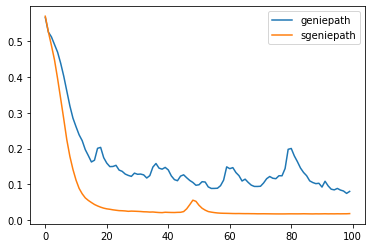

In [8]:
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_ppigeniepath,label="geniepath")

plt.plot(losslist_agnn,label="sgeniepath")


plt.legend(loc=0, ncol=1) 
plt.savefig('./agnn_ppi对比.jpg')
plt.show()